In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import random
import numpy as np
from torchvision import transforms
import torchvision.io as io
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
import cv2
import json
import os

In [2]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads, attn_dropout=0.0, proj_dropout=0.0):
        super().__init__()
        assert dim % num_heads == 0, "dim must be divisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_dropout)

    def forward(self, x):
        """
        x: (B, N, D)
        """
        B, N, D = x.shape

        qkv = self.qkv(x)                      # (B, N, 3D)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)        # (3, B, H, N, Hd)

        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        out = attn @ v                         # (B, H, N, Hd)
        out = out.transpose(1, 2).reshape(B, N, D)

        out = self.proj(out)
        out = self.proj_drop(out)
        return out
    
class MLP(nn.Module):  # SwiGLU
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.w_gate = nn.Linear(dim, hidden_dim, bias=True)
        self.w_value = nn.Linear(dim, hidden_dim, bias=True)
        self.w_out = nn.Linear(hidden_dim, dim, bias=True)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        gate = F.silu(self.w_gate(x))     # SiLU on gate
        value = self.w_value(x)
        x = gate * value
        x = self.w_out(x)
        x = self.drop(x)
        return x
    
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        # x: (B, N, D)
        # Calculate RMS: sqrt(mean(x^2))
        rms = torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return x * rms * self.weight
    
class TransformerEncoderBlock(nn.Module):
    def __init__(
        self,
        dim,
        num_heads,
        mlp_ratio=3.0,
        attn_dropout=0.0,
        dropout=0.0
    ):
        super().__init__()

        self.norm1 = RMSNorm(dim)
        self.attn = MultiHeadSelfAttention(
            dim, num_heads, attn_dropout, dropout
        )

        self.norm2 = RMSNorm(dim)
        self.mlp = MLP(
            dim,
            int(dim * mlp_ratio),
            dropout
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))   # Pre-LN
        x = x + self.mlp(self.norm2(x))
        return x
    
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, in_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size

        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        """
        x: (B, C, H, W)
        """
        x = self.proj(x)          # (B, D, H/P, W/P)
        H, W = x.shape[-2:]
        x = x.flatten(2).transpose(1, 2)  # (B, N, D)
        return x, (H, W)


class VisionTransformer(nn.Module):
    def __init__(
        self,
        patch_size=16,
        in_channels=3,
        embed_dim=192,
        depth=6,
        num_heads=3,
        mlp_ratio=3.0,
        dropout=0.0,
        attn_dropout=0.0,
        base_grid_size=(16, 16),  # reference size (e.g. 256/16)
    ):
        super().__init__()

        self.patch_embed = PatchEmbedding(
            patch_size, in_channels, embed_dim
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        num_base_patches = base_grid_size[0] * base_grid_size[1]
        self.pos_embed = nn.Parameter(
            torch.zeros(1, num_base_patches + 1, embed_dim)
        )

        self.pos_drop = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(
                embed_dim,
                num_heads,
                mlp_ratio,
                attn_dropout,
                dropout
            )
            for _ in range(depth)
        ])

        self.norm = RMSNorm(embed_dim)
        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def interpolate_pos_encoding(self, x, grid_hw):
        """
        x: (B, N+1, D)
        grid_hw: (H, W) patch grid
        """
        cls_pos = self.pos_embed[:, :1]
        patch_pos = self.pos_embed[:, 1:]

        H0 = W0 = int(patch_pos.shape[1] ** 0.5)
        patch_pos = patch_pos.reshape(1, H0, W0, -1).permute(0, 3, 1, 2)

        patch_pos = F.interpolate(
            patch_pos,
            size=grid_hw,
            mode="bicubic",
            align_corners=False
        )

        patch_pos = patch_pos.permute(0, 2, 3, 1).reshape(1, -1, patch_pos.shape[1])
        return torch.cat((cls_pos, patch_pos), dim=1)

    def forward(self, x):
        """
        x: (B, C, H, W)
        """
        B = x.shape[0]

        x, (H, W) = self.patch_embed(x)  # (B, N, D)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        pos_embed = self.interpolate_pos_encoding(x, (H, W))
        x = x + pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x

In [3]:
class DINOHead(nn.Module):
    def __init__(
        self, 
        in_dim, 
        out_dim=65280, 
        hidden_dim=1536, 
        bottleneck_dim=384
    ):
        super().__init__()

        self.mlp = nn.Sequential(
                    nn.Linear(in_dim, hidden_dim),
                    nn.GELU(),
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.GELU(),
                    nn.Linear(hidden_dim, bottleneck_dim),
                )

        # 2. The Weight Norm Layer (The "Prototypes")
        self.last_layer = torch.nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
        
        # 3. DINO specific init: Freeze weight magnitude to 1
        self.last_layer.weight_g.data.fill_(1)
        self.last_layer.weight_g.requires_grad = False
        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # x: (B, in_dim) - comes from the ViT backbone
        x = self.mlp(x)
        
        # Normalize features to make them lie on a hypersphere
        x = F.normalize(x, dim=-1, p=2)
        
        # Dot product with normalized prototypes
        x = self.last_layer(x)
        return x
    
class DINOWrapper(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        # 1. Get features from clean backbone
        features = self.backbone(x)[:,0] # cls token only
        
        # 2. Project features through DINO head
        projections = self.head(features)
        
        return projections

In [4]:
student_backbone = VisionTransformer(
    patch_size=16,
    embed_dim=192
)

teacher_backbone = VisionTransformer(
    patch_size=16,
    embed_dim=192
)

# 2. Instantiate the DINO Heads
student_head = DINOHead(in_dim=192, out_dim=24000) # 24000 multiple 192 or choose 65280 around 65k in official paper.
teacher_head = DINOHead(in_dim=192, out_dim=24000)

# 3. Wrap them
student = DINOWrapper(student_backbone, student_head)
teacher = DINOWrapper(teacher_backbone, teacher_head)

# 4. Copy student weights to teacher initially (Standard DINO practice)
teacher.load_state_dict(student.state_dict())

# 5. Disable gradients for Teacher (Teacher is updated via EMA, not Backprop)
for param in teacher.parameters():
    param.requires_grad = False

print("Models ready for DINO training.")

/Users/saptarshimallikthakur/Pictures/VLM/.venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Models ready for DINO training.


In [5]:
summary(
    student_backbone,
    input_size=(1, 3, 96, 96),
    col_names=("input_size", "output_size", "num_params", "trainable"),
)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
VisionTransformer                             [1, 3, 96, 96]            [1, 37, 192]              49,536                    True
├─PatchEmbedding: 1-1                         [1, 3, 96, 96]            [1, 36, 192]              --                        True
│    └─Conv2d: 2-1                            [1, 3, 96, 96]            [1, 192, 6, 6]            147,648                   True
├─Dropout: 1-2                                [1, 37, 192]              [1, 37, 192]              --                        --
├─ModuleList: 1-3                             --                        --                        --                        True
│    └─TransformerEncoderBlock: 2-2           [1, 37, 192]              [1, 37, 192]              --                        True
│    │    └─RMSNorm: 3-1                      [1, 37, 192]              [1, 37, 192]          

In [6]:
summary(
    student,
    input_size=(1, 3, 96, 96),
    col_names=("input_size", "output_size", "num_params", "trainable"),
)

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
DINOWrapper                                        [1, 3, 96, 96]            [1, 24000]                --                        Partial
├─VisionTransformer: 1-1                           [1, 3, 96, 96]            [1, 37, 192]              49,536                    True
│    └─PatchEmbedding: 2-1                         [1, 3, 96, 96]            [1, 36, 192]              --                        True
│    │    └─Conv2d: 3-1                            [1, 3, 96, 96]            [1, 192, 6, 6]            147,648                   True
│    └─Dropout: 2-2                                [1, 37, 192]              [1, 37, 192]              --                        --
│    └─ModuleList: 2-3                             --                        --                        --                        True
│    │    └─TransformerEncoderBlock: 3-2           [1, 3

In [7]:
file_path = "/Users/saptarshimallikthakur/Pictures/detection daatset/COCO/coco_train_captions.jsonl"
coco_image_folder = "/Users/saptarshimallikthakur/Pictures/detection daatset/COCO/train2017"

rows = []
with open(file_path, "r") as f:
    for line in f:
        item = json.loads(line)
        img_id = str(item['image_id']).zfill(12)       # ensure 12-digit string
        img_file = f"{img_id}.jpg"
        img_path = os.path.join(coco_image_folder, img_file)
        
        # Add row
        rows.append({
            'img_path': img_path,
        })

df = pd.DataFrame(rows)
df

,img_path
0,/Users/saptarshimallikthakur/Pictures/detectio...
1,/Users/saptarshimallikthakur/Pictures/detectio...
2,/Users/saptarshimallikthakur/Pictures/detectio...
3,/Users/saptarshimallikthakur/Pictures/detectio...
4,/Users/saptarshimallikthakur/Pictures/detectio...
...,...
134267,/Users/saptarshimallikthakur/Pictures/detectio...
134268,/Users/saptarshimallikthakur/Pictures/detectio...
134269,/Users/saptarshimallikthakur/Pictures/detectio...
134270,/Users/saptarshimallikthakur/Pictures/detectio...


In [8]:
BATCH_SIZE = 32

class DINODataAugmentation:
    def __init__(self, global_crops_number=2, local_crops_number=8):

        # 1. Global Augmentation
        self.global_transfo = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ConvertImageDtype(torch.float),
            transforms.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225))
        ])

        # 2. Local Augmentation
        self.local_transfo = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ConvertImageDtype(torch.float),
            transforms.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225))
        ])

        self.global_crops_number = global_crops_number
        self.local_crops_number = local_crops_number


    def __call__(self, image):
        crops = []

        # Global crops
        for _ in range(self.global_crops_number):
            img = transforms.RandomResizedCrop(256, scale=(0.4, 1.0))(image)
            crops.append(self.global_transfo(img))

        # Local crops
        for _ in range(self.local_crops_number):
            img = transforms.RandomResizedCrop(96, scale=(0.05, 0.4))(image)
            crops.append(self.local_transfo(img))

        return crops
    
class MyDataset(Dataset):
    def __init__(self, df, max_samples=None):
        self.df = df.sample(n=max_samples) if max_samples else df
        self.aug = DINODataAugmentation()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = io.read_image(row['img_path'])

        if img.shape[0] == 1:   # If grayscale → repeat channels
            img = img.repeat(3, 1, 1)
        elif img.shape[0] >= 4:
            img = img[:3,:,:]
            
        crops = self.aug(img)
        return crops
    
def dino_collate_fn(batch):
    '''
    INPUT: 
    
    [global_1, global_2,      # 2 global crops
            local_1, ..., local_8    # 8 local crops]

    batch = [
        [c1_1, c1_2, ..., c1_10],  # sample 1
        [c2_1, c2_2, ..., c2_10],  # sample 2
        ...
        [c32_1, c32_2, ..., c32_10]  # sample 32
        ]

    batch = [32 samples][10 crops each][3 × H × W]

    OUTPUT :

    transposed = [
    (c1_1, c2_1, ..., c32_1),   # crop index 0 (global)
    (c1_2, c2_2, ..., c32_2),   # crop index 1 (global)
    (c1_3, c2_3, ..., c32_3),   # local
    ...
    ]

    tensor_crops = [torch.stack(crops) for crops in transposed]

    tensor_crops = [
    Tensor(32, 3, 256, 256),  # global crop 1
    Tensor(32, 3, 256, 256),  # global crop 2
    Tensor(32, 3, 96, 96),    # local crop 1
    ...
    ]

    '''
    transposed = list(zip(*batch))
    tensor_crops = [torch.stack(crops) for crops in transposed]
    return tensor_crops

dataset = MyDataset(df)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=dino_collate_fn,
)

In [9]:
class DINOLoss(nn.Module):
    def __init__(self, out_dim, teacher_temp=0.04, student_temp=0.1, center_momentum=0.9):
        super().__init__()
        self.student_temp = student_temp
        self.teacher_temp = teacher_temp
        self.center_momentum = center_momentum
        self.register_buffer("center", torch.zeros(1, out_dim))

    def forward(self, student_output, teacher_output, epoch):
        """
        student_output: [n_crops * B, out_dim] 
        teacher_output: [2 * B, out_dim]
        """
        # Softmax and Sharpening
        student_out = student_output / self.student_temp
        
        n_crops = len(student_output) // (len(teacher_output) // 2)
        student_out = student_out.chunk(n_crops) 

        # Teacher centering and sharpening
        teacher_out = F.softmax((teacher_output - self.center) / self.teacher_temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(2)

        total_loss = 0
        n_loss_terms = 0

        # 2. Cross-Entropy
        for i_t, t_out in enumerate(teacher_out):
            for i_s, s_out in enumerate(student_out):
                if i_t == i_s:
                    continue
                
                # Now t_out is [B, dim] and s_out is [B, dim]
                loss = torch.sum(-t_out * F.log_softmax(s_out, dim=-1), dim=-1)
                total_loss += loss.mean()
                n_loss_terms += 1

        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        return total_loss

    @torch.no_grad()
    def update_center(self, teacher_output):
        """
        Update center used for teacher output centering.
        """
        batch_center = torch.sum(teacher_output, dim=0, keepdim=True)
        batch_center = batch_center / len(teacher_output) # Mean of batch
        
        # EMA update
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)

In [ ]:
# --- SETUP ---
device = 'mps'

student = student.to(device)
teacher = teacher.to(device)

dino_loss = DINOLoss(out_dim=24000).to(device)

optimizer = torch.optim.Adam(student.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
momentum_schedule = np.linspace(0.996, 1.0, 100) 

# -----------------------------------------------------------
# TRAINING LOOP
# -----------------------------------------------------------
epochs = 10
print(f"Starting training on {device}...")

for epoch in range(epochs):
    student.train()
    teacher.train()
    
    total_loss = 0
    m = momentum_schedule[epoch]
    
    # 1. Wrap dataloader with tqdm
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{epochs}")
    
    for i, images in pbar:
        global_imgs = torch.cat(images[:2]).to(device)
        local_imgs  = torch.cat(images[2:]).to(device)

        with torch.no_grad():
            teacher_output = teacher(global_imgs)

        student_global_out = student(global_imgs)
        student_local_out = student(local_imgs)
        student_output = torch.cat([student_global_out, student_local_out], dim=0)
        
        loss = dino_loss(student_output, teacher_output, epoch)
        
        optimizer.zero_grad()
        loss.backward()
        param_norms = torch.nn.utils.clip_grad_norm_(student.parameters(), 3.0)
        optimizer.step()
        
        with torch.no_grad():
            for param_q, param_k in zip(student.parameters(), teacher.parameters()):
                param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)

        total_loss += loss.item()
        
        # 2. Update progress bar with current loss
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")
    
    torch.save({
        'student': student.state_dict(),
        'teacher': teacher.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, f"dino_checkpoint_coco.pth")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image

In [ ]:
backbone = VisionTransformer(
    patch_size=16,
    embed_dim=192
)

ckpt = torch.load("dino_checkpoint.pth", map_location="cpu")

student_state = ckpt["student"]

# Extract only backbone weights
backbone_state = {
    k.replace("backbone.", ""): v
    for k, v in student_state.items()
    if k.startswith("backbone.")
}

# Load into backbone
backbone.load_state_dict(backbone_state, strict=True)
backbone.eval()

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-5): 6 x TransformerEncoderBlock(
      (norm1): RMSNorm()
      (attn): MultiHeadSelfAttention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): RMSNorm()
      (mlp): MLP(
        (w_gate): Linear(in_features=192, out_features=576, bias=True)
        (w_value): Linear(in_features=192, out_features=576, bias=True)
        (w_out): Linear(in_features=576, out_features=192, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): RMSNorm()
)

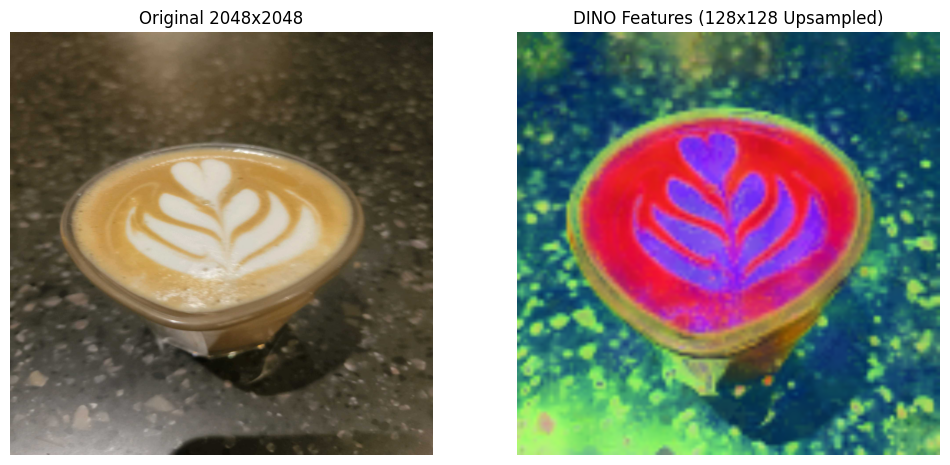

In [ ]:
# 1. Setup
IMG_SIZE = 2048
transform_high_res = transforms.Compose([
    transforms.Resize(IMG_SIZE, interpolation=3),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 2. Load
img_path = "/Users/saptarshimallikthakur/Pictures/VLM/sharan_startup/Latte Art-Nymbleup/2025-06-02/Cortado/alwarpet_store_Cortado.jpg" 
raw_image = Image.open(img_path).convert('RGB')
x = transform_high_res(raw_image).unsqueeze(0)

# 3. Inference
with torch.no_grad():
    # CORRECTED LINE: No [0] index here
    patch_tokens = backbone.forward(x)[0,1:]

# 4. Grid Calc
h, w = x.shape[2] // 16, x.shape[3] // 16 

# 5. PCA
patch_tokens = patch_tokens / patch_tokens.norm(dim=-1, keepdim=True)
pca = PCA(n_components=3)
pca_features = pca.fit_transform(patch_tokens.numpy())
pca_features = (pca_features - pca_features.min(0)) / (pca_features.max(0) - pca_features.min(0))

# 6. Reshape & Upsample
feature_map = pca_features.reshape(h, w, 3)
feature_tensor = torch.from_numpy(feature_map).permute(2, 0, 1).unsqueeze(0)
upsampled_features = F.interpolate(
    feature_tensor, 
    size=(IMG_SIZE, IMG_SIZE), 
    mode='bilinear', 
    align_corners=False
).squeeze(0).permute(1, 2, 0).numpy()

# 7. Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(raw_image.resize((IMG_SIZE, IMG_SIZE)))
ax[0].set_title(f"Original {IMG_SIZE}x{IMG_SIZE}")
ax[0].axis('off')

ax[1].imshow(upsampled_features)
ax[1].set_title(f"DINO Features ({h}x{w} Upsampled)")
ax[1].axis('off')

plt.show()

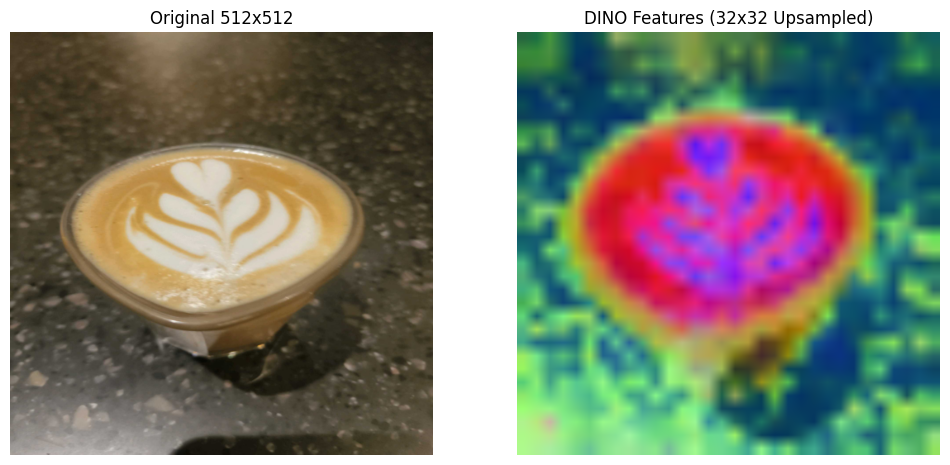

In [ ]:
# 1. Setup
IMG_SIZE = 512
transform_high_res = transforms.Compose([
    transforms.Resize(IMG_SIZE, interpolation=3),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 2. Load
img_path = "/Users/saptarshimallikthakur/Pictures/VLM/sharan_startup/Latte Art-Nymbleup/2025-06-02/Cortado/alwarpet_store_Cortado.jpg" 
raw_image = Image.open(img_path).convert('RGB')
x = transform_high_res(raw_image).unsqueeze(0)

# 3. Inference
with torch.no_grad():
    # CORRECTED LINE: No [0] index here
    patch_tokens = backbone.forward(x)[0,1:]

# 4. Grid Calc
h, w = x.shape[2] // 16, x.shape[3] // 16 

# 5. PCA
patch_tokens = patch_tokens / patch_tokens.norm(dim=-1, keepdim=True)
pca = PCA(n_components=3)
pca_features = pca.fit_transform(patch_tokens.numpy())
pca_features = (pca_features - pca_features.min(0)) / (pca_features.max(0) - pca_features.min(0))

# 6. Reshape & Upsample
feature_map = pca_features.reshape(h, w, 3)
feature_tensor = torch.from_numpy(feature_map).permute(2, 0, 1).unsqueeze(0)
upsampled_features = F.interpolate(
    feature_tensor, 
    size=(IMG_SIZE, IMG_SIZE), 
    mode='bilinear', 
    align_corners=False
).squeeze(0).permute(1, 2, 0).numpy()

# 7. Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(raw_image.resize((IMG_SIZE, IMG_SIZE)))
ax[0].set_title(f"Original {IMG_SIZE}x{IMG_SIZE}")
ax[0].axis('off')

ax[1].imshow(upsampled_features)
ax[1].set_title(f"DINO Features ({h}x{w} Upsampled)")
ax[1].axis('off')

plt.show()

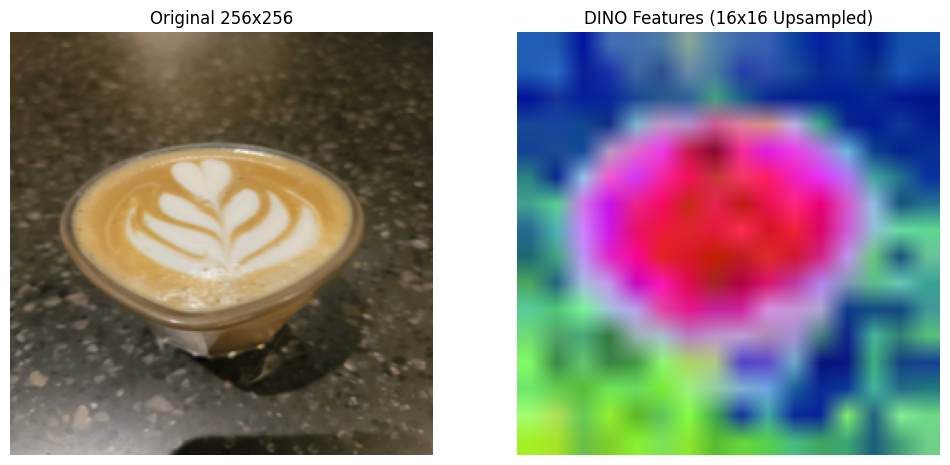

In [ ]:
# 1. Setup
IMG_SIZE = 256
transform_high_res = transforms.Compose([
    transforms.Resize(IMG_SIZE, interpolation=3),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 2. Load
img_path = "/Users/saptarshimallikthakur/Pictures/VLM/sharan_startup/Latte Art-Nymbleup/2025-06-02/Cortado/alwarpet_store_Cortado.jpg" 
raw_image = Image.open(img_path).convert('RGB')
x = transform_high_res(raw_image).unsqueeze(0)

# 3. Inference
with torch.no_grad():
    patch_tokens = backbone.forward(x)[0,1:] # [B, 1 + N, D] --> [N,D]

# 4. Grid Calc
h, w = x.shape[2] // 16, x.shape[3] // 16 

# 5. PCA
patch_tokens = patch_tokens / patch_tokens.norm(dim=-1, keepdim=True)
pca = PCA(n_components=3) # [N,3]
pca_features = pca.fit_transform(patch_tokens.numpy())

# Min-max normalization → [0,1] Needed for visualization
pca_features = (pca_features - pca_features.min(0)) / (pca_features.max(0) - pca_features.min(0))

# 6. Reshape & Upsample
feature_map = pca_features.reshape(h, w, 3) # [n,n,3] where : n = sqrt(N)
feature_tensor = torch.from_numpy(feature_map).permute(2, 0, 1).unsqueeze(0)
upsampled_features = F.interpolate(
    feature_tensor, 
    size=(IMG_SIZE, IMG_SIZE), 
    mode='bilinear', 
    align_corners=False
).squeeze(0).permute(1, 2, 0).numpy()

# 7. Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(raw_image.resize((IMG_SIZE, IMG_SIZE)))
ax[0].set_title(f"Original {IMG_SIZE}x{IMG_SIZE}")
ax[0].axis('off')

ax[1].imshow(upsampled_features)
ax[1].set_title(f"DINO Features ({h}x{w} Upsampled)")
ax[1].axis('off')

plt.show()

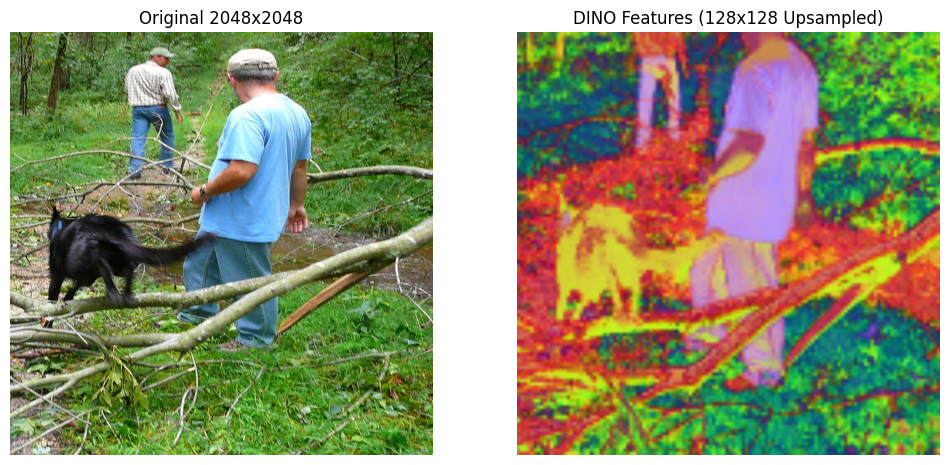

In [ ]:
# 1. Setup
IMG_SIZE = 2048
transform_high_res = transforms.Compose([
    transforms.Resize(IMG_SIZE, interpolation=3),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 2. Load
img_path = "/Users/saptarshimallikthakur/Pictures/vik_lnqa/train-00023-of-00199/0be3ae1c7aa72a6c.jpg"  
raw_image = Image.open(img_path).convert('RGB')
x = transform_high_res(raw_image).unsqueeze(0)

# 3. Inference
with torch.no_grad():
    # CORRECTED LINE: No [0] index here
    patch_tokens = backbone.forward(x)[0,1:]

# 4. Grid Calc
h, w = x.shape[2] // 16, x.shape[3] // 16 

# 5. PCA
patch_tokens = patch_tokens / patch_tokens.norm(dim=-1, keepdim=True)
pca = PCA(n_components=3)
pca_features = pca.fit_transform(patch_tokens.numpy())
pca_features = (pca_features - pca_features.min(0)) / (pca_features.max(0) - pca_features.min(0))

# 6. Reshape & Upsample
feature_map = pca_features.reshape(h, w, 3)
feature_tensor = torch.from_numpy(feature_map).permute(2, 0, 1).unsqueeze(0)
upsampled_features = F.interpolate(
    feature_tensor, 
    size=(IMG_SIZE, IMG_SIZE), 
    mode='bilinear', 
    align_corners=False
).squeeze(0).permute(1, 2, 0).numpy()

# 7. Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(raw_image.resize((IMG_SIZE, IMG_SIZE)))
ax[0].set_title(f"Original {IMG_SIZE}x{IMG_SIZE}")
ax[0].axis('off')

ax[1].imshow(upsampled_features)
ax[1].set_title(f"DINO Features ({h}x{w} Upsampled)")
ax[1].axis('off')

plt.show()

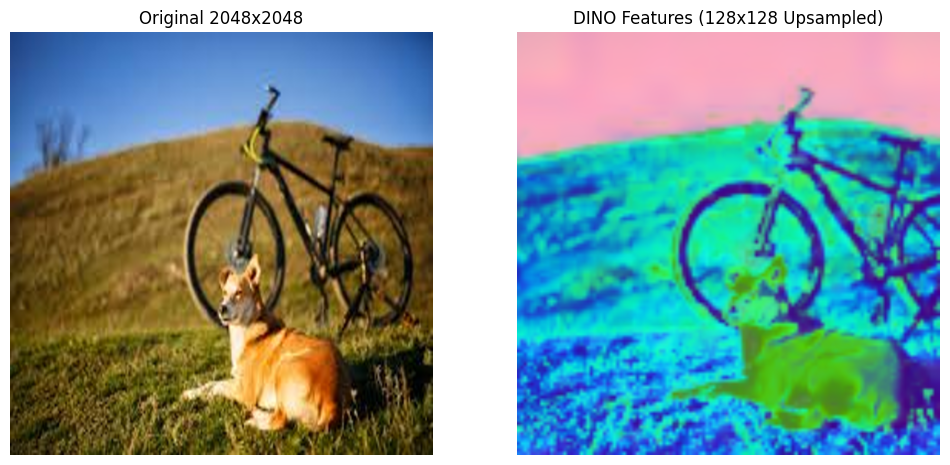

In [ ]:
# 1. Setup
IMG_SIZE = 2048
transform_high_res = transforms.Compose([
    transforms.Resize(IMG_SIZE, interpolation=3),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 2. Load
img_path = "/Users/saptarshimallikthakur/Pictures/New Folder With Items/dog2.jpeg"  
raw_image = Image.open(img_path).convert('RGB')
x = transform_high_res(raw_image).unsqueeze(0)

# 3. Inference
with torch.no_grad():
    # CORRECTED LINE: No [0] index here
    patch_tokens = backbone.forward(x)[0,1:]

# 4. Grid Calc
h, w = x.shape[2] // 16, x.shape[3] // 16 

# 5. PCA
patch_tokens = patch_tokens / patch_tokens.norm(dim=-1, keepdim=True)
pca = PCA(n_components=3)
pca_features = pca.fit_transform(patch_tokens.numpy())
pca_features = (pca_features - pca_features.min(0)) / (pca_features.max(0) - pca_features.min(0))

# 6. Reshape & Upsample
feature_map = pca_features.reshape(h, w, 3)
feature_tensor = torch.from_numpy(feature_map).permute(2, 0, 1).unsqueeze(0)
upsampled_features = F.interpolate(
    feature_tensor, 
    size=(IMG_SIZE, IMG_SIZE), 
    mode='bilinear', 
    align_corners=False
).squeeze(0).permute(1, 2, 0).numpy()

# 7. Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(raw_image.resize((IMG_SIZE, IMG_SIZE)))
ax[0].set_title(f"Original {IMG_SIZE}x{IMG_SIZE}")
ax[0].axis('off')

ax[1].imshow(upsampled_features)
ax[1].set_title(f"DINO Features ({h}x{w} Upsampled)")
ax[1].axis('off')

plt.show()